# Facial Landmarks Localization using CelebA Dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
from fastai import *
from fastai.vision import *

In [3]:
path = Path('data/CelebA')

In [4]:
path.ls()

[PosixPath('data/CelebA/list_bbox_celeba.csv'),
 PosixPath('data/CelebA/Test'),
 PosixPath('data/CelebA/list_landmarks_align_celeba.csv'),
 PosixPath('data/CelebA/list_attr_celeba.csv'),
 PosixPath('data/CelebA/celeba-dataset.zip'),
 PosixPath('data/CelebA/img_align_celeba.zip'),
 PosixPath('data/CelebA/img_align_celeba'),
 PosixPath('data/CelebA/.ipynb_checkpoints'),
 PosixPath('data/CelebA/list_eval_partition.csv')]

In [5]:
path_img = path/'img_align_celeba'

### This path contains more than 200,000 image files !!!!.  
We will first explore the data, move out the test set and then start modeling

In [134]:
img_files = get_image_files(path_img)

In [135]:
img_files[0:5]

[PosixPath('data/CelebA/img_align_celeba/092887.jpg'),
 PosixPath('data/CelebA/img_align_celeba/006156.jpg'),
 PosixPath('data/CelebA/img_align_celeba/047999.jpg'),
 PosixPath('data/CelebA/img_align_celeba/095668.jpg'),
 PosixPath('data/CelebA/img_align_celeba/102903.jpg')]

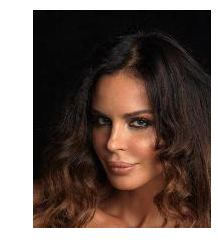

In [138]:
# Displaying an image
img = open_image(img_files[1])
img.show(figsize=(4,4))

In [139]:
img.shape

torch.Size([3, 218, 178])

According to the README all images are size 218 x 178 

In [8]:
# Reading in the landmarks data
df = pd.read_csv(path/'list_landmarks_align_celeba.csv')

In [9]:
df.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


We see the dataframe contains the file names along with pixel positions of the landmarks

## Displaying facial landmarks with matplotlib

In [10]:
coords = df.iloc[0]
coords

image_id        000001.jpg
lefteye_x               69
lefteye_y              109
righteye_x             106
righteye_y             113
nose_x                  77
nose_y                 142
leftmouth_x             73
leftmouth_y            152
rightmouth_x           108
rightmouth_y           154
Name: 0, dtype: object

In [11]:
# Getting the pixel data in the format required
x_coords = coords.values[1::2]
y_coords = coords.values[2::2]
x_coords,y_coords

(array([69, 106, 77, 73, 108], dtype=object),
 array([109, 113, 142, 152, 154], dtype=object))

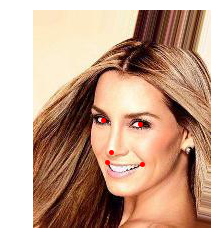

In [12]:
img = plt.imread(path_img/coords[0])
plt.imshow(img)
plt.scatter(x_coords,y_coords,c='r',s=15)
plt.axis('off')
plt.show()

## Displaying with fastai buit-ins

In [13]:
def plot_pts(img,pts):
    return ImagePoints(FlowField(img.size,pts),scale=True)

In [14]:
coords = df.iloc[1]
coords

image_id        000002.jpg
lefteye_x               69
lefteye_y              110
righteye_x             107
righteye_y             112
nose_x                  81
nose_y                 135
leftmouth_x             70
leftmouth_y            151
rightmouth_x           108
rightmouth_y           153
Name: 1, dtype: object

In [15]:
# Getting the pixel data in the format required
pts = tensor(coords[1:]).float().reshape(-1,2).flip(1)
pts

tensor([[110.,  69.],
        [112., 107.],
        [135.,  81.],
        [151.,  70.],
        [153., 108.]])

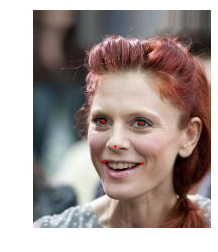

In [16]:
img2 = open_image(path_img/coords[0])
img2.show(y=plot_pts(img2,pts),figsize=(4,4))

In [17]:
img2.shape

torch.Size([3, 218, 178])

In [18]:
path.ls()

[PosixPath('data/CelebA/list_bbox_celeba.csv'),
 PosixPath('data/CelebA/Test'),
 PosixPath('data/CelebA/list_landmarks_align_celeba.csv'),
 PosixPath('data/CelebA/list_attr_celeba.csv'),
 PosixPath('data/CelebA/celeba-dataset.zip'),
 PosixPath('data/CelebA/img_align_celeba.zip'),
 PosixPath('data/CelebA/img_align_celeba'),
 PosixPath('data/CelebA/.ipynb_checkpoints'),
 PosixPath('data/CelebA/list_eval_partition.csv')]

In [19]:
# This CSV file contains the partition for train test sets
part = pd.read_csv(path/'list_eval_partition.csv')

In [20]:
part.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [21]:
part.loc[part.partition == 2].index

Int64Index([182637, 182638, 182639, 182640, 182641, 182642, 182643, 182644,
            182645, 182646,
            ...
            202589, 202590, 202591, 202592, 202593, 202594, 202595, 202596,
            202597, 202598],
           dtype='int64', length=19962)

In [22]:
# # Moving out the test set
# l =sorted(path_img.ls())
# for p in l[182637:]:
#     shutil.move(str(p),str(path/'Test'))

In [23]:
# Getting the landmark pixel location from file name in the desired format 
def label_points(fname):
    #print(fname)
    return tensor(df[df.image_id == fname.name].squeeze()[1:]).float().reshape(-1,2).flip(1)

In [90]:
# Reading in the images
IL = ImageImageList.from_folder(path_img,num_cpus=8)

In [91]:
# Training using only 50,000 image due to compute restrictions
IL.items  = IL.items[:50000]

In [92]:
# Sanity Checking 'label_points'
label_points(IL.items[0])

tensor([[111.,  69.],
        [111., 108.],
        [136.,  86.],
        [152.,  75.],
        [152., 102.]])

In [93]:
%%time
src = (IL
       .random_split_by_pct(0.15)
       .label_from_func(label_points,label_cls=PointsItemList))
       

CPU times: user 11min 14s, sys: 264 ms, total: 11min 14s
Wall time: 11min 14s


In [94]:
# Data block api
data = (src.transform(get_transforms(), tfm_y=True) 
       .databunch(bs=64).normalize(imagenet_stats))

In [95]:
def _plot(ds,rows=4):
    dl = iter(ds)
    fig = plt.figure(figsize=(rows*3,rows*3))
    for i in range(rows*rows):
        x,y = next(dl)
        ax = fig.add_subplot(rows,rows,i+1)
        x.show(ax,y=y)

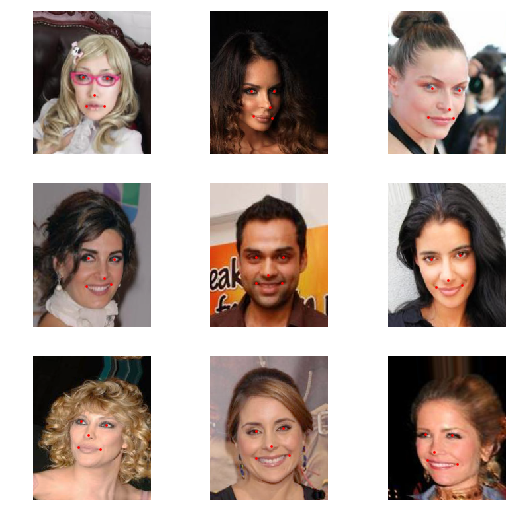

In [96]:
# Plotting few examples from the training set with the landmarks
_plot(data.train_ds,rows=3)

In [97]:
# Transfer Learning using a Resnet34 
learn = create_cnn(data,models.resnet34)
learn.loss_func = MSELossFlat()

In [98]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


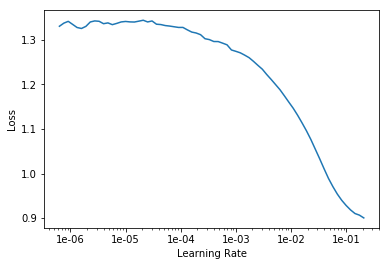

In [99]:
learn.recorder.plot()

In [100]:
lr = 1e-2

In [101]:
learn.fit_one_cycle(7,slice(lr))

epoch,train_loss,valid_loss
1,0.032898,0.020345
2,0.022636,0.019134
3,0.020712,0.015366
4,0.019772,0.020667
5,0.018907,0.015159
6,0.017614,0.016066
7,0.017267,0.016009


In [102]:
# Unfreezing the entire model and training using discrimative LRs
learn.unfreeze()

In [103]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


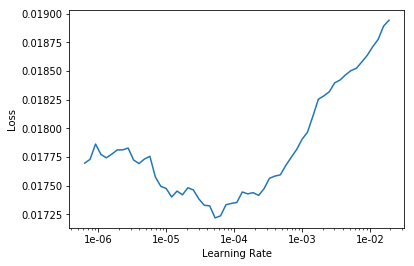

In [112]:
learn.recorder.plot(skip_end=10)

In [113]:
lrs = slice(1e-5,lr/5)

In [114]:
learn.fit_one_cycle(7,lrs)

epoch,train_loss,valid_loss
1,0.016591,0.014788
2,0.015898,0.013513
3,0.014154,0.011048
4,0.013060,0.018471
5,0.011612,0.008620
6,0.010396,0.009945
7,0.009932,0.009889


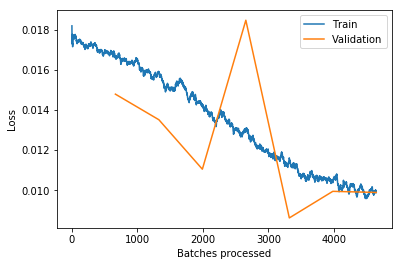

In [115]:
learn.recorder.plot_losses()

In [116]:
learn.save('50k-stage-2')

In [117]:
learn.load('50k-stage-2');

In [122]:
# Doing it once more
learn.unfreeze()
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


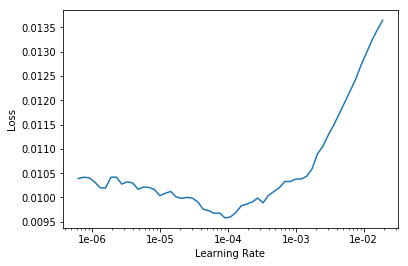

In [124]:
learn.recorder.plot(skip_end=10)

In [125]:
lrs = slice(1e-5,lr/10)

In [126]:
learn.fit_one_cycle(5,lrs)

epoch,train_loss,valid_loss
1,0.010159,0.009805
2,0.009200,0.010494
3,0.007888,0.006561
4,0.006087,0.004727
5,0.005768,0.005901


In [127]:
learn.save('50k-stage-2')

In [128]:
learn.load('50k-stage-2');

In [129]:
# Moving over to the test path
path_test = path/'Test'

In [130]:
def plot_test_set(num=10):
    img_test = np.random.choice(path_test.ls(),num,replace=False)
    axes = plt.subplots(num,2,figsize=(10,4*num))[1]
    axes[0,0].set_title('Predictions')
    axes[0,1].set_title('Ground Truth')
    for i,file in enumerate(img_test):
        img = open_image(file)
        img.show(axes[i,0],y=learn.predict(img)[0])
        img.show(axes[i,1],y=plot_pts(img,label_points(file)))

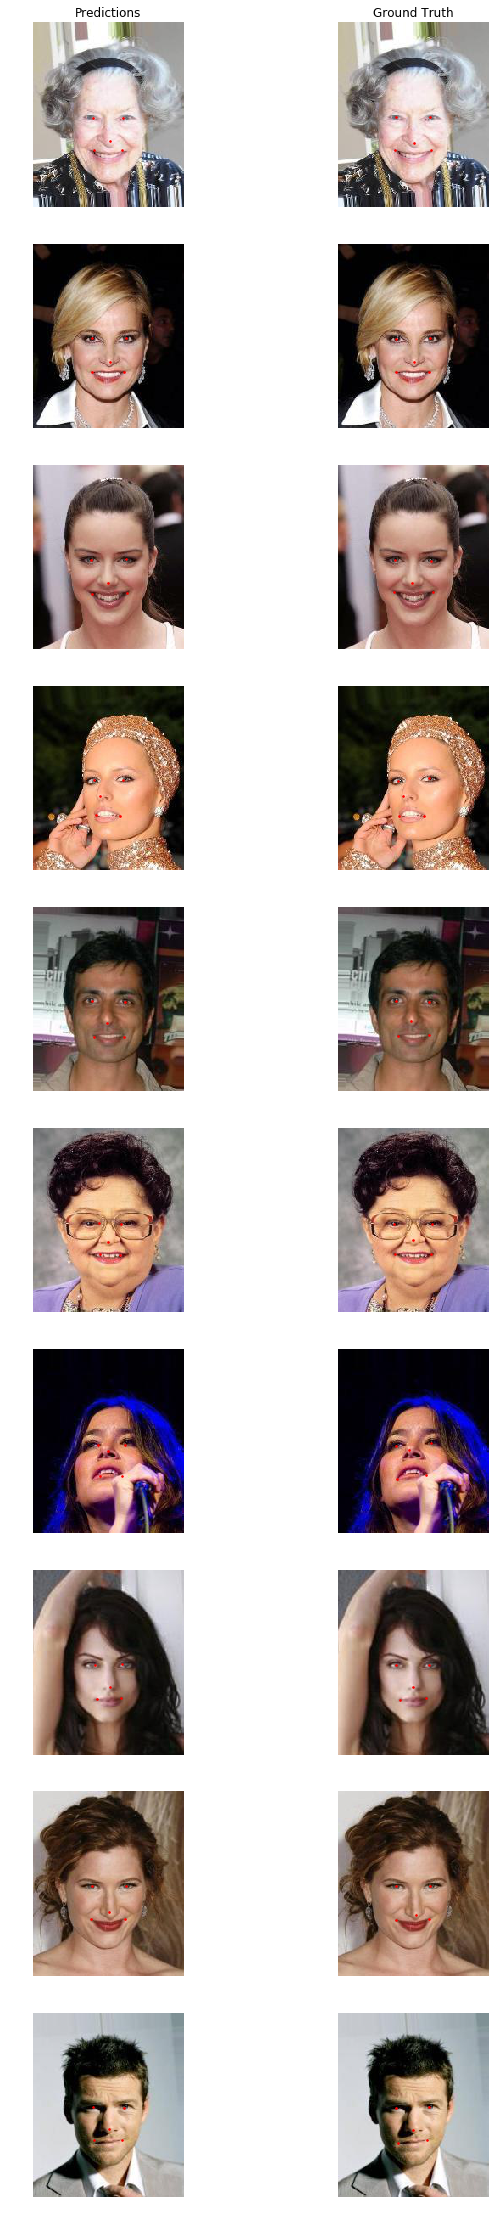

In [131]:
# Plotting 10 random examples from the test set with landmark predictions and ground truth
plot_test_set(10)